In [1]:
import os, sys, argparse
import pandas as pd
import numpy as np

import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
parser = argparse.ArgumentParser(description='heatmap creator')
parser.add_argument('-o', '--output', type=str, default='-', action='store', help='target')
parser.add_argument('-d', '--data', type=str, default='alpha', choices=['alpha', 'amazon', 'epinions', 'otc'], help='data name')
parser.add_argument('-a', '--alg', type=str, default='bad', choices=['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad'], help='alg name')

if bool(getattr(sys, 'ps1', sys.flags.interactive)):
    from tqdm import tqdm_notebook as tqdm
    print('interactive mode')
    parsed = parser.parse_args(['--data', 'alpha', '--alg', 'bn'])
else:
    from tqdm import tqdm
    print('script mode')
    parsed = parser.parse_args(sys.argv[1:])
    display=print

print(parsed)

interactive mode
Namespace(alg='bn', data='alpha', output='-')


In [3]:
# alg_list = ['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad', 'rev2']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
# data_list = ['alpha', 'amazon', 'epinions', 'otc']
data_list = ['otc', 'alpha', 'epinions', 'amazon']
q_range = np.array([0.005, 0.01, 0.03, 0.05, 0.1])
met_list = ['f1', 'prec', 'recl']

k_range = np.arange(10) / 10
n_range = list(range(0, 51, 5))
n_range[0] = 1

In [4]:
def plot_one_heatmap(fig, ax, plot_data, title=''):
    heat = ax.pcolor(plot_data)
    
    u_new = plot_data[1:, :].min()
    u_old = plot_data[0, :].mean()
    
    k_new, n_new = np.unravel_index(plot_data[1:, :].argmin(), plot_data[1:, :].shape)
    # because k_new starts from 1
    k_new += 1
    # print(k_range[k_new], n_range[n_new])
    
    u_change = (u_new - u_old) / u_old
    t = '%s\n new %.3f, old %.3f, change %.3f\n k: %.1f, N:%d' %(title, u_new, u_old, u_change, k_range[k_new], n_range[n_new])
    ax.set_title(t)

    ax.set_xticks(range(len(n_range)))
    ax.set_xticklabels(n_range)

    ax.set_yticks(range(len(k_range)))
    ax.set_yticklabels(k_range)

    ax.set_xlabel('N: number of fair reviews')
    ax.set_ylabel('k: fraction of sockpuppets')

    return heat, [u_change, k_range[k_new], n_range[n_new]]

In [5]:
def create_heatmaps(alg, data):
    eval_path = '../res/%s/eval-%s.pkl' %(alg, data)
    print(eval_path)
    if not os.path.exists(eval_path):
        print(alg, data, 'not exists')
        return None, {qq: {met: None for met in met_list} for qq in q_range}
    
    with open(eval_path, 'rb') as fp:
        metrics_dict = pickle.load(fp)
    
    q_dict = {}
    ret = {}
    for q in range(5):
        heat_dict = {'f1': np.empty([10, 11]), 'prec': np.empty([10, 11]), 'recl': np.empty([10, 11])}
        
        for k, n in itertools.product(range(10), range(11)):
            heat_dict['f1'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50) if metrics_dict[(k, n_range[n], ind)] != None])
            heat_dict['prec'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50) if metrics_dict[(k, n_range[n], ind)] != None])
            heat_dict['recl'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50) if metrics_dict[(k, n_range[n], ind)] != None])
        q_dict[q] = heat_dict
    
    
    figs = []
#     for q in range(5):
#         fig, axes = plt.subplots(1, 3, figsize=(10, 3))
        
#         ret[q_range[q]] = {}
#         h1,r1 = plot_one_heatmap(fig, axes[0], q_dict[q]['f1'], title='f1 score @ q %.1f%%' %(q_range[q]*100))
#         h2,r2 = plot_one_heatmap(fig, axes[1], q_dict[q]['prec'], title='precision @ q %.1f%%' %(q_range[q]*100))
#         h3,r3 = plot_one_heatmap(fig, axes[2], q_dict[q]['recl'], title='recall @ q %.1f%%' %(q_range[q]*100))
#         ret[q_range[q]]['f1'] = r1
#         ret[q_range[q]]['prec'] = r2
#         ret[q_range[q]]['recl'] = r3
        
#         fig.colorbar(h1)
#         fig.tight_layout()
#         figs.append(fig)
    
    fig, axes = plt.subplots(3, 5, figsize=(16, 9))
    for q in range(5):
        ret[q_range[q]] = {}
        h1,r1 = plot_one_heatmap(fig, axes[0, q], q_dict[q]['f1'], title='f1 score @ q %.1f%%' %(q_range[q]*100))
        h2,r2 = plot_one_heatmap(fig, axes[1, q], q_dict[q]['prec'], title='precision @ q %.1f%%' %(q_range[q]*100))
        h3,r3 = plot_one_heatmap(fig, axes[2, q], q_dict[q]['recl'], title='recall @ q %.1f%%' %(q_range[q]*100))
        ret[q_range[q]]['f1'] = r1
        ret[q_range[q]]['prec'] = r2
        ret[q_range[q]]['recl'] = r3
    cbar = fig.colorbar(h1)
    fig.tight_layout()
    figs.append(fig)
    
    return figs, ret

../res/rsd/eval-amazon.pkl


,0.005,0.01,0.03,0.05,0.1
f1,"[-0.9484060038934595, 0.8, 5]","[-0.9416421305269004, 0.8, 5]","[-0.8958931711130484, 0.8, 5]","[-0.8230246970762972, 0.8, 5]","[-0.648659716456495, 0.9, 1]"
prec,"[-0.11494252873563232, 0.4, 5]","[-0.05874840357598992, 0.5, 30]","[0.07843137254901977, 0.2, 15]","[0.03299838729686172, 0.2, 15]","[0.15739289881646923, 0.1, 25]"
recl,"[-0.9717931302581863, 0.8, 5]","[-0.9682043947825468, 0.8, 5]","[-0.9431942447483185, 0.8, 5]","[-0.9017293131540777, 0.8, 5]","[-0.8096675970820931, 0.9, 1]"


../res/feagle/eval-amazon.pkl


,0.005,0.01,0.03,0.05,0.1
f1,"[-0.9490179405794661, 0.8, 1]","[-0.9426215802163888, 0.8, 1]","[-0.8983012780405836, 0.8, 1]","[-0.8591190475399922, 0.6, 40]","[-0.7316613294453926, 0.6, 40]"
prec,"[-0.23462783171521032, 0.6, 40]","[-0.20496224379719521, 0.6, 40]","[-0.1535752401280682, 0.2, 1]","[-0.14762771688649456, 0.2, 1]","[-0.009752667121486367, 0.1, 40]"
recl,"[-0.9716917299215322, 0.8, 1]","[-0.9682071667684746, 0.8, 1]","[-0.9435757502770031, 0.8, 1]","[-0.9204576805056017, 0.6, 40]","[-0.8544432309100406, 0.9, 45]"


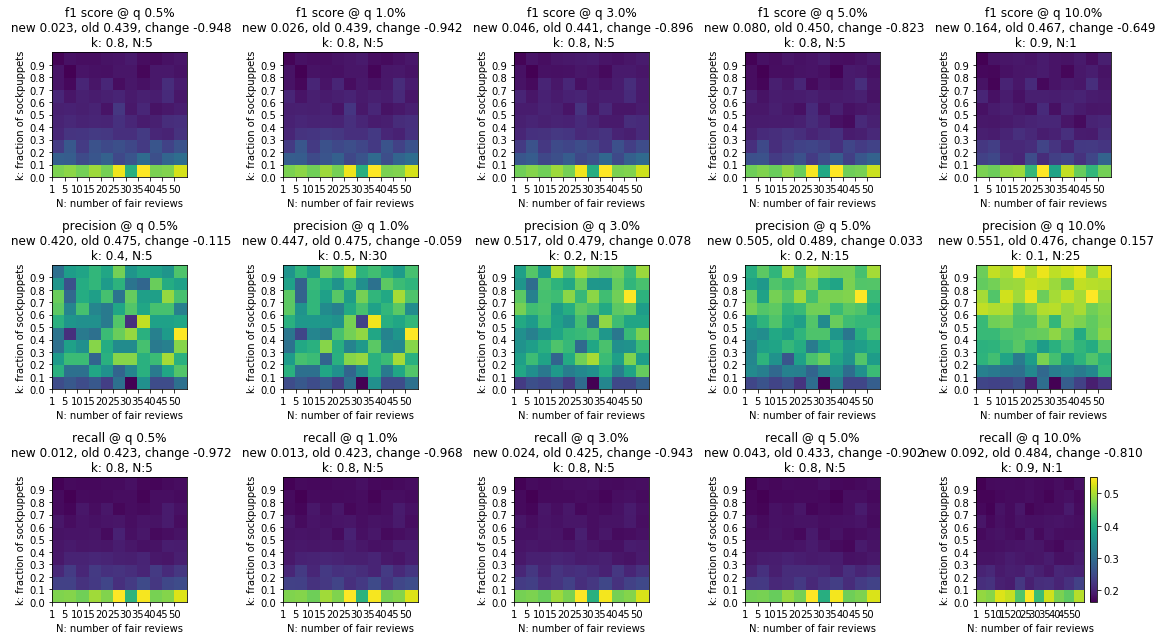

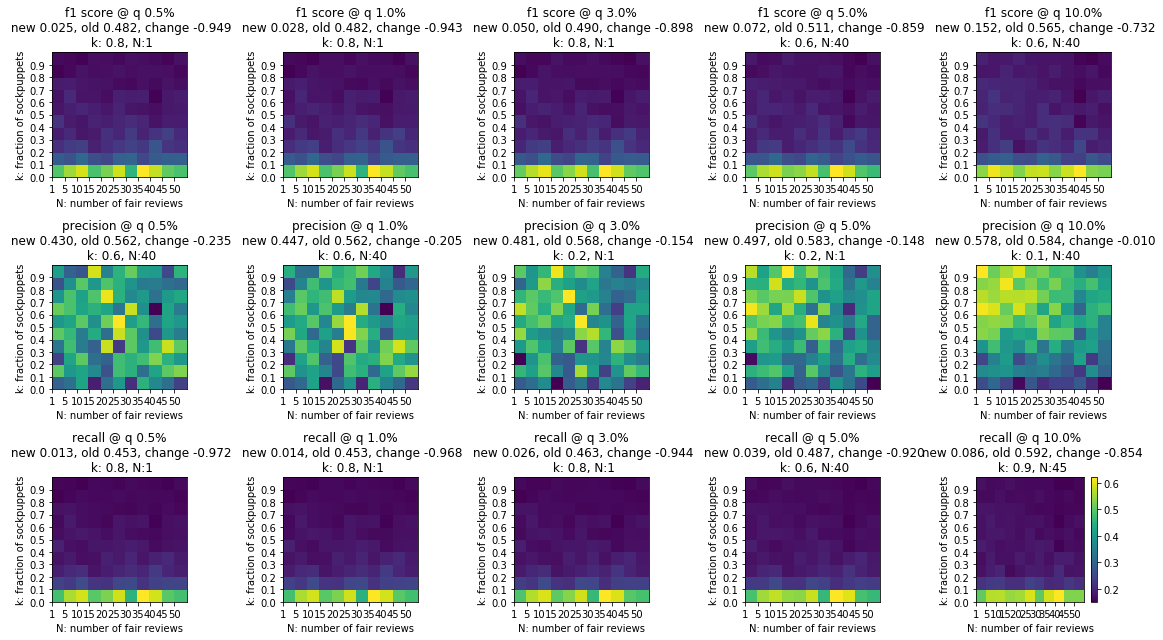

In [6]:
fig, ret = create_heatmaps(alg='rsd', data='amazon')
display(pd.DataFrame(ret))
fig, ret = create_heatmaps(alg='feagle', data='amazon')
display(pd.DataFrame(ret))

In [7]:
reports = {met: {q: {alg: {data: {} for data in data_list} for alg in alg_list} for q in q_range} for met in met_list}

for alg in alg_list:
    for data in data_list:
        print(alg, data)
        figs, ret = create_heatmaps(alg, data)
        if figs != None:
            for i in range(len(figs)):
                fig = figs[i]
                fig.savefig('../res/heatmaps/%s-%s-%d.pdf' %(alg, data, i))
        plt.close('all')
        # pd.DataFrame(ret).to_csv('../res/heatmaps/%s-%s.csv' %(alg, data))
        for q in q_range:
            for met in met_list:
                if ret[q][met] != None:
                    reports[met][q][alg][data] = '%.3f \n k=%.2f \n n=%d' %tuple(ret[q][met])
                else:
                    reports[met][q][alg][data] = ''

rev2 otc
../res/rev2/eval-otc.pkl
rev2 alpha
../res/rev2/eval-alpha.pkl
rev2 epinions
../res/rev2/eval-epinions.pkl
rev2 amazon
../res/rev2/eval-amazon.pkl
bad otc
../res/bad/eval-otc.pkl
bad alpha
../res/bad/eval-alpha.pkl
bad epinions
../res/bad/eval-epinions.pkl
bad amazon
../res/bad/eval-amazon.pkl
bn otc
../res/bn/eval-otc.pkl
bn alpha
../res/bn/eval-alpha.pkl
bn epinions
../res/bn/eval-epinions.pkl
bn amazon
../res/bn/eval-amazon.pkl
trust otc
../res/trust/eval-otc.pkl
trust alpha
../res/trust/eval-alpha.pkl
trust epinions
../res/trust/eval-epinions.pkl
trust amazon
../res/trust/eval-amazon.pkl
feagle otc
../res/feagle/eval-otc.pkl
feagle alpha
../res/feagle/eval-alpha.pkl
feagle epinions
../res/feagle/eval-epinions.pkl
feagle amazon
../res/feagle/eval-amazon.pkl
fraudar otc
../res/fraudar/eval-otc.pkl
fraudar alpha
../res/fraudar/eval-alpha.pkl
fraudar epinions
../res/fraudar/eval-epinions.pkl
fraudar amazon
../res/fraudar/eval-amazon.pkl
rsd otc
../res/rsd/eval-otc.pkl
rsd alph

In [8]:
for met in met_list:
    for q in q_range:
        print(met, q)
        df = pd.DataFrame(reports[met][q]).loc[data_list]
        df.to_csv('../res/heatmaps/%s-%.3f.csv' %(met, q))

f1 0.005
f1 0.01
f1 0.03
f1 0.05
f1 0.1
prec 0.005
prec 0.01
prec 0.03
prec 0.05
prec 0.1
recl 0.005
recl 0.01
recl 0.03
recl 0.05
recl 0.1
